# Data Scientist - P7 - Laurent Trichet

## Implémentez un modèle de scoring

## 3 Evaluation of model, global and local importance, with SHAP

### Import required libraries

In [1]:
# Import default libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Import Garbage Collector (empty dataFrame memory)
import gc

# Import Imbalanced-learn necessary tools
import imblearn
from collections import Counter

# import for classification GradientBoostingClassifier
from sklearn import ensemble

# Import split tool for training and evaluation sets production
from sklearn.model_selection import train_test_split

# Import shap
import shap

# Import mlflow, serialization and model server
import mlflow.shap

# tools for execution time estimates
from datetime import datetime

# Remove some warnings
import warnings
warnings.filterwarnings('ignore')

# Matplotlib and sns visual parameters
sns.set_palette("Set1")
sns.set_style('whitegrid')
sns.set_context('paper')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11

# Constants
DIRDATASET = './credithome_datasets/'
NUMROWS = 15000       # 1000000 = total dataset
# File names with NUMROWS lines, Fill nan with zeros and important features only
FILESTD_FNAN0_REDUCED = DIRDATASET+'Credit_Home_Junction_Std_Fnan0_Reduced_'+str(NUMROWS)+'.csv'


### Create datasets

In [2]:
df = pd.read_csv(FILESTD_FNAN0_REDUCED, encoding='Latin-1', sep='\t')

# Retrieve train and test datasets
df_train = df[df['TARGET']!=999]
df_test = df[df['TARGET']==999]
# Keep valid columns for features and result class in future classifications
c_features = [c for c in df.columns if c not in ['index', 'TARGET', 'SK_ID_CURR']]
c_class = 'TARGET'
del df
gc.collect()

# Fix imbalanced classes
counter1 = Counter(df_train[c_class])
undersample = imblearn.under_sampling.RandomUnderSampler(random_state=0)
X, y = undersample.fit_resample(df_train[c_features+[c_class]], df_train[c_class])
counter2 = Counter(y)
print(f'imbalance fixed, from {counter1} to {counter2}')

# Define dataset of class 0 and class 1
X_class0 = X[X[c_class]==0][c_features]
X_class1 = X[X[c_class]==1][c_features]

# Keep features columns only
X = X[c_features]
X_test = df_test[c_features]
del df_train, df_test
gc.collect()

# Split original training into training and eval for model interpretation
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=7)

print(f'X        {str(X.shape)}, y       {str(y.shape)}')
print(f'X_train  {str(X_train.shape)}, y_train {str(y_train.shape)}')
print(f'X_eval   {str(X_eval.shape)}, y_eval  {str(y_eval.shape)}')
print(f'X_class0 {str(X_class0.shape)}')
print(f'X_class1 {str(X_class1.shape)}')
print(f'X_test   {str(X_test.shape)}')

imbalance fixed, from Counter({1.0: 13826, 0.0: 1174}) to Counter({0.0: 1174, 1.0: 1174})
X        (2348, 213), y       (2348,)
X_train  (1878, 213), y_train (1878,)
X_eval   (470, 213), y_eval  (470,)
X_class0 (1174, 213)
X_class1 (1174, 213)
X_test   (15000, 213)


### Fit GBC model

In [3]:
gbc = ensemble.GradientBoostingClassifier(
                n_estimators=200,
                max_depth=3,
                criterion='friedman_mse',
                min_samples_split = 4,
                min_weight_fraction_leaf = 0.2
                )
gbc.fit(X, y)

GradientBoostingClassifier(min_samples_split=4, min_weight_fraction_leaf=0.2,
                           n_estimators=200)

In [4]:
print(f'score training set = {np.round(gbc.score(X_train, y_train), 2)}')
print(f'score evaluation set = {np.round(gbc.score(X_eval, y_eval), 2)}')

score training set = 0.77
score evaluation set = 0.81


### Shap global interpretations

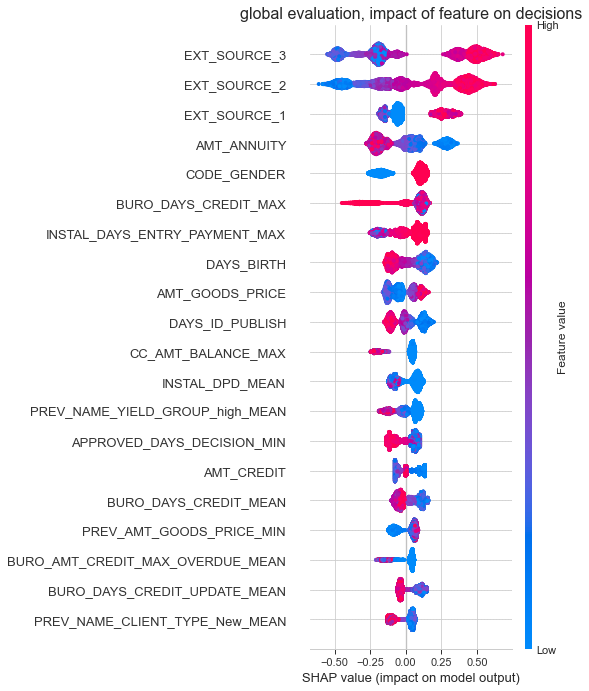

In [26]:
explainer = shap.TreeExplainer(gbc)
base_values = X_test
shap_values = explainer.shap_values(base_values)
shap_interaction = explainer.shap_interaction_values(base_values)
fig, ax = plt.subplots(figsize=(12,10))
shap.summary_plot(shap_values, base_values, show=False)
ax.set_title('global evaluation, impact of feature on decisions')
plt.show()

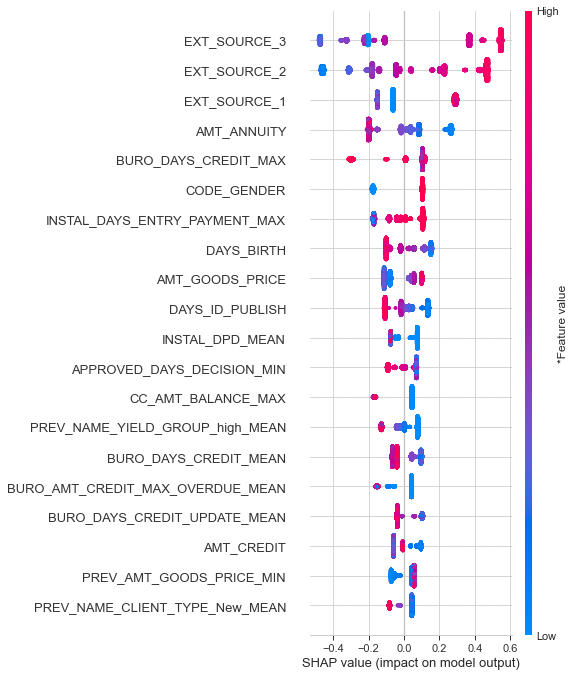

In [27]:
shap.summary_plot(shap_interaction, base_values, plot_type='compact_dot')


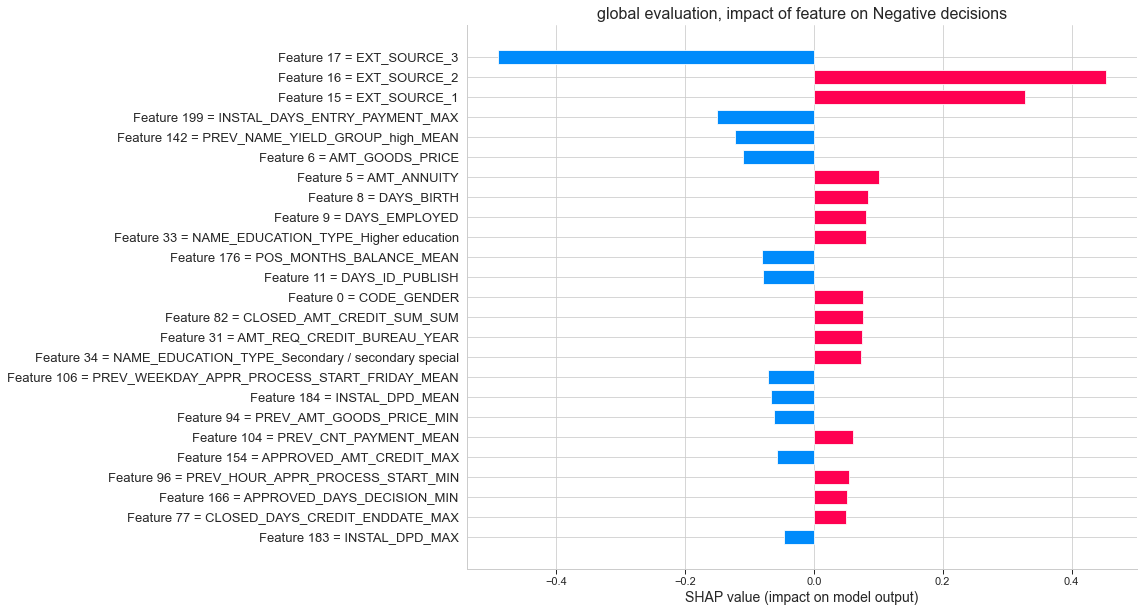

In [28]:
fig, ax = plt.subplots(figsize=(12,10))
shap.bar_plot(shap_values[0], c_features, max_display=25, show=False)
ax.set_title('global evaluation, impact of feature on Negative decisions')
plt.show()

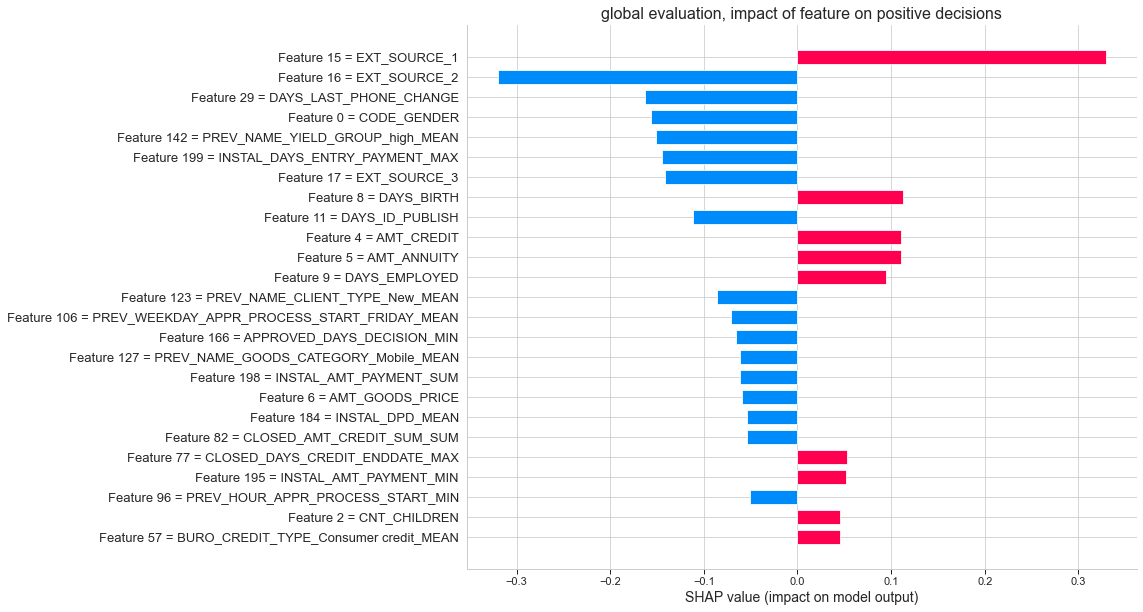

In [29]:
fig, ax = plt.subplots(figsize=(12,10))
shap.bar_plot(shap_values[1], c_features, max_display=25, show=False)
ax.set_title('global evaluation, impact of feature on positive decisions')
plt.show()

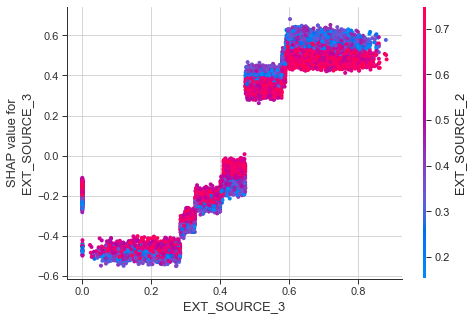

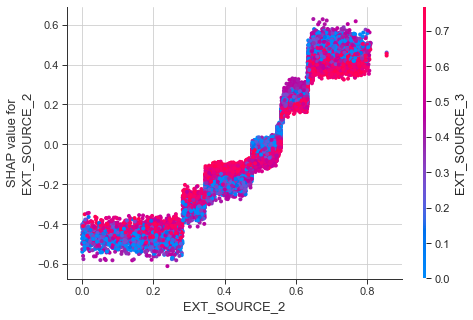

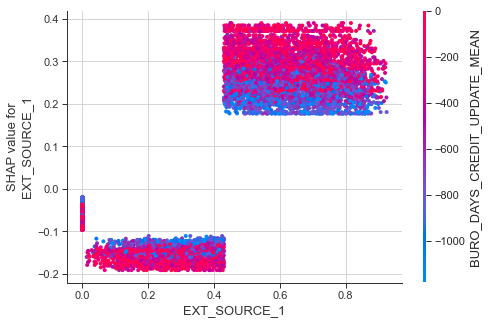

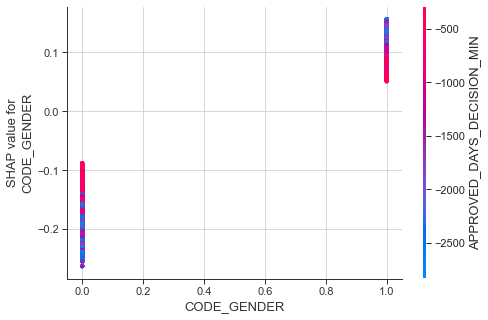

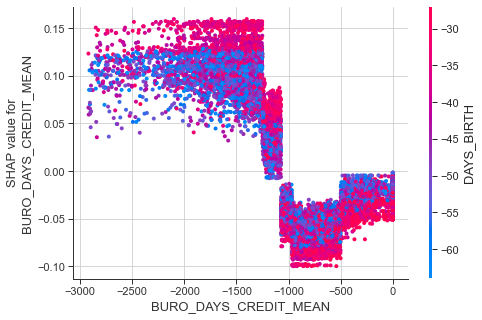

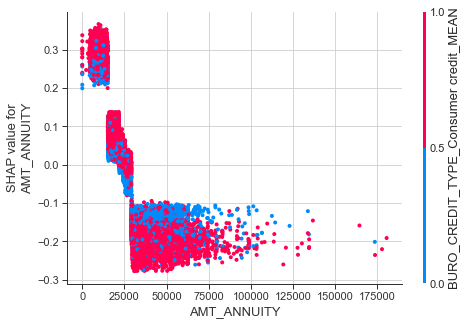

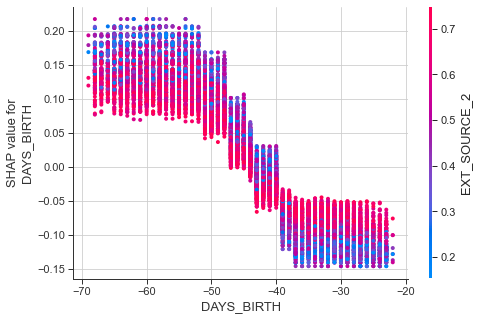

In [30]:
col_ = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'CODE_GENDER', 'BURO_DAYS_CREDIT_MEAN', 'AMT_ANNUITY', 'DAYS_BIRTH']
for col in col_:
    shap.dependence_plot(col, shap_values, base_values)


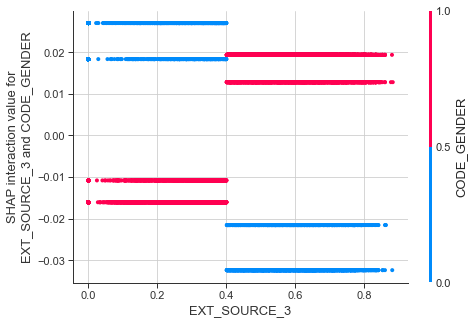

In [31]:
col_ = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'CODE_GENDER', 'BURO_DAYS_CREDIT_MEAN', 'AMT_ANNUITY', 'DAYS_BIRTH']
shap.dependence_plot(("EXT_SOURCE_3","CODE_GENDER"), shap_interaction, base_values)


##### Global impact
> confirmation of most influential features retrieved with permutation techniques.  
> 3 first ext sources confirm their importance, high values influencing high values in score (left cloud on the right) and resp.  
> Gender is strangely separated with high values (women) influencing high score and respectively men influencing low score.

### Shap local interpretation

In [39]:
explainer = shap.TreeExplainer(gbc)
base_values = X_test
shap_values = explainer.shap_values(base_values)
shap_expected = explainer.expected_value
shap_interaction = explainer.shap_interaction_values(base_values)

In [40]:
shap.initjs()
shap.force_plot(shap_expected[0], shap_values[0], feature_names=c_features)

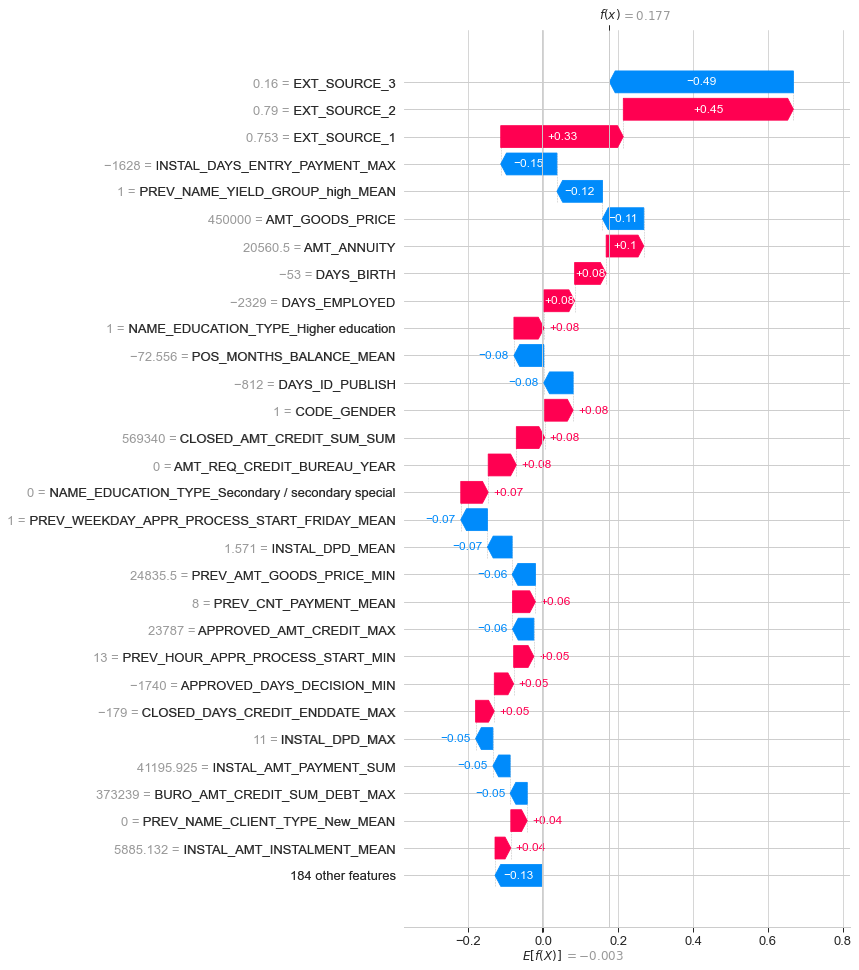

In [34]:
shap_values = explainer(base_values)
shap.waterfall_plot(shap_values[0], max_display=30)